In [1]:
import sys

MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [2]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils.load import add_noise, load_data
from utils.params import set_param

import warnings

warnings.filterwarnings("ignore")

sns.set_theme(style="ticks")
np.random.seed(42)

In [3]:
exp = "p4581"
params = set_param(exp)

dirs = {"main": MAIN_DICT}
dirs["data"] = dirs["main"] + "/data/" + params["dir_data"]

X, Y, t, dt, vl = load_data(exp, dirs, params)
Y = Y[:, 0:2]

In [4]:
df = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[
        "det_shear_stress",
        "obs_shear_stress",
        "obs_normal_stress",
        "time",
    ],
)
df.head()

,det_shear_stress,obs_shear_stress,obs_normal_stress,time
0,0.002811,1.29911,2.99288,0.000
1,0.002731,1.29903,2.99008,0.001
2,0.002231,1.29853,2.98854,0.002
3,0.002411,1.29871,2.98849,0.003
4,0.002241,1.29854,2.99069,0.004


In [5]:
df = df.iloc[::100]

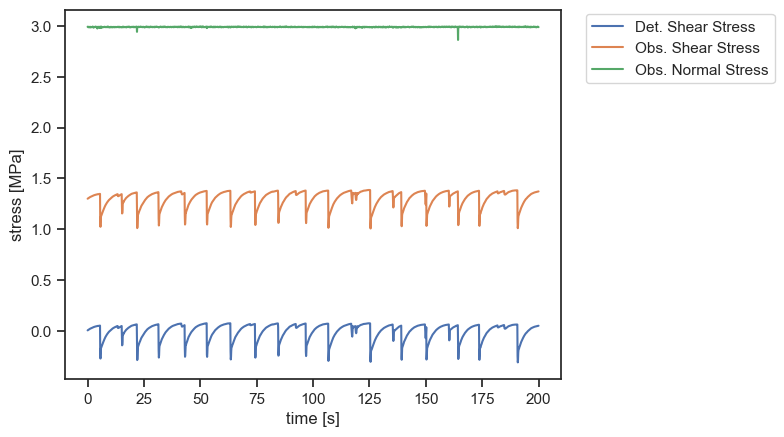

In [6]:
plt.plot(df["time"], df["det_shear_stress"], label="Det. Shear Stress")
plt.plot(df["time"], df["obs_shear_stress"], label="Obs. Shear Stress")
plt.plot(df["time"], df["obs_normal_stress"], label="Obs. Normal Stress")
plt.legend(loc=(1.05, 0.8))
plt.xlabel("time [s]")
plt.ylabel("stress [MPa]")
plt.show()

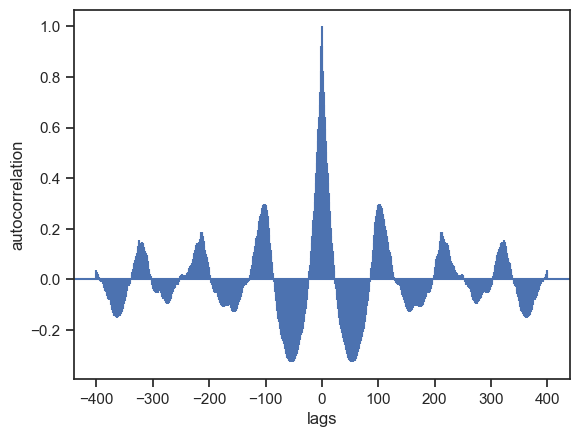

In [7]:
plt.acorr(df["det_shear_stress"], maxlags=400)[1][1]
plt.xlabel("lags")
plt.ylabel("autocorrelation")
plt.show();

In [8]:
RATIO = 0.80
LENGTH = df.shape[0]

train_data = df.iloc[: int(RATIO * LENGTH)]
test_data = df.iloc[int(RATIO * LENGTH) :]

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import optuna
import joblib

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 10) for x in list(itertools.product(p, d, q))]


def objective_sarima(trial):
    length = len(train_data)
    train_data_obj = train_data["det_shear_stress"].iloc[: int(RATIO * length)]
    valid_data_obj = train_data["det_shear_stress"].iloc[int(RATIO * length) :]

    order = trial.suggest_categorical("order", pdq)
    seasonal_order = trial.suggest_categorical("seasonal_order", pdqs)
    trend = trial.suggest_categorical("trend", ["n", "c", "t", "ct", None])
    model = SARIMAX(
        train_data_obj,
        order=order,
        seasonal_order=seasonal_order,
        trend=trend,
        initialization="approximate_diffuse",
    )
    model = model.fit(maxiter=100, disp=0)
    predictions = model.forecast(len(valid_data_obj))
    predictions = pd.Series(predictions, index=valid_data_obj.index)
    residuals = valid_data_obj.values - predictions.values
    mse = np.mean(residuals**2)
    accuracy = mse
    return accuracy


if os.path.isfile("models/p4581_detshearstress_sarima_study.pkl"):
    study = joblib.load("models/p4581_detshearstress_sarima_study.pkl")
else:
    study = optuna.create_study()
    study.optimize(objective_sarima, n_trials=10, timeout=3600)
    joblib.dump(study, "models/p4581_detshearstress_sarima_study.pkl")

In [10]:
trial = study.best_trial
print("Accuracy: {}".format(trial.value))
print("Best params for SARIMAX: {}".format(trial.params))

Accuracy: 0.0043441921096489975
Best params for SARIMAX: {'order': (2, 0, 0), 'seasonal_order': (0, 0, 0, 10), 'trend': 't'}


In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train_data["det_shear_stress"],
    initialization="approximate_diffuse",
    **trial.params,
)

model = model.fit(disp=0)

/home/users/p341cam/miniconda3/envs/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


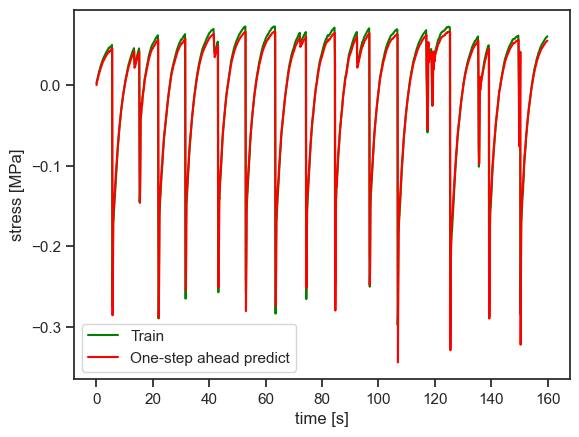

In [12]:
predict_train = model.predict(0, train_data["time"].shape[0])[:-1]

plt.plot(train_data["time"], train_data["det_shear_stress"], color="green")
plt.plot(train_data["time"], predict_train, color="red")
plt.legend(["Train", "One-step ahead predict"])
plt.xlabel("time [s]")
plt.ylabel("stress [MPa]")
plt.show()

In [13]:
from sklearn.metrics import r2_score, mean_squared_error

print(
    f"Train R^2 Score:  {r2_score(predict_train, train_data['det_shear_stress']):.5f}"
)
print(
    f"Train RMSE Score: {np.sqrt(mean_squared_error(predict_train, train_data['det_shear_stress'])):.5f}"
)

Train R^2 Score:  0.83537
Train RMSE Score: 0.02753


In [14]:
test_model = SARIMAX(
    df["det_shear_stress"],
    initialization="approximate_diffuse",
    **trial.params,
)

test_model = test_model.filter(model.params)

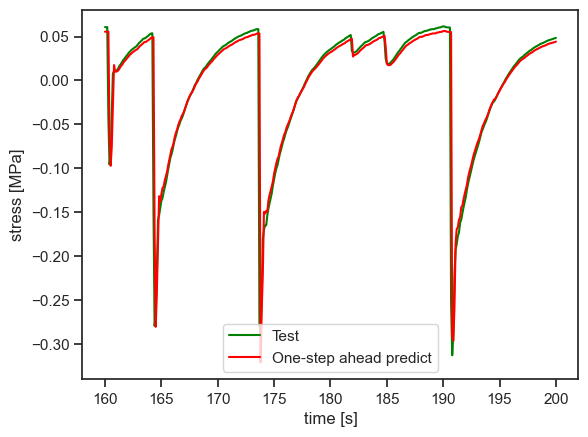

In [15]:
predict_test = test_model.predict(
    train_data["time"].shape[0], df["time"].shape[0]
)[:-1]

plt.plot(test_data["time"], test_data["det_shear_stress"], color="green")
plt.plot(test_data["time"], predict_test, color="red")
plt.legend(["Test", "One-step ahead predict"])
plt.xlabel("time [s]")
plt.ylabel("stress [MPa]")
plt.show()

In [16]:
from sklearn.metrics import r2_score, mean_squared_error

print(
    f"Test R^2 Score:  {r2_score(predict_test, test_data['det_shear_stress']):.5f}"
)
print(
    f"Test RMSE Score: {np.sqrt(mean_squared_error(predict_test, test_data['det_shear_stress'])):.5f}"
)

Test R^2 Score:  0.84871
Test RMSE Score: 0.02648


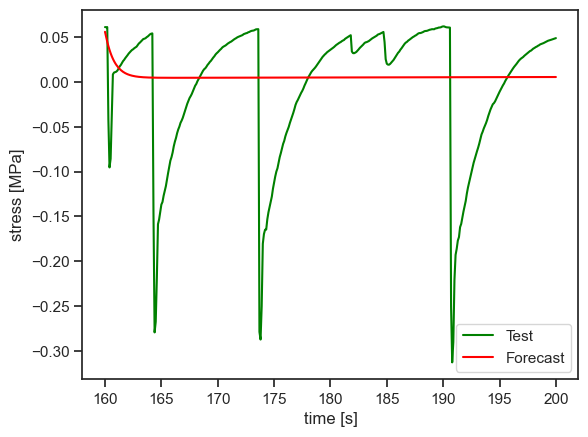

In [17]:
forecasts = model.forecast(len(test_data))
forecasts = pd.Series(forecasts, index=test_data.index)

plt.plot(test_data["time"], test_data["det_shear_stress"], color="green")
plt.plot(test_data["time"], forecasts, color="red")
plt.legend(["Test", "Forecast"])
plt.xlabel("time [s]")
plt.ylabel("stress [MPa]")
plt.show()

In [18]:
from sklearn.metrics import r2_score, mean_squared_error

print(
    f"Forecast R^2 Score:  {r2_score(forecasts, test_data['det_shear_stress']):.5f}"
)
print(
    f"Forecast RMSE Score: {np.sqrt(mean_squared_error(forecasts, test_data['det_shear_stress'])):.5f}"
)

Forecast R^2 Score:  -198.30051
Forecast RMSE Score: 0.07414
